In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error


In [34]:
# Converts a list of time-series data in to supervised data set.
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = list()

    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))

    for i in range(0, n_out):
        cols.append(df.shift(-i))

    agg = pd.concat(cols, axis=1)
    if dropnan:
        agg.dropna(inplace=True)

    return agg.values


In [35]:
tsa = series_to_supervised([100, 110, 108, 115, 120])


In [36]:
ts = pd.DataFrame(tsa)
ts.columns = ['X', 'y']

In [37]:
ts

,X,y
0,100.0,110.0
1,110.0,108.0
2,108.0,115.0
3,115.0,120.0


In [38]:
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:,:]

In [39]:
# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
	train = np.asarray(train)

	# splot into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]

	# fit model
	model = RandomForestRegressor(n_estimators=1000)
	model.fit(trainX, trainy)

	# make a one-step prediction
	yhat = model.predict([testX])
	return yhat[0]


In [40]:
# Walk-forward validation for univariate data


def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)

    # Seed history with training dataset
    history = [x for x in train]

    # Step over each time-step in the test set
    for i in range(len(test)):

        # Split test tow into input and output columns
        testX, testy = test[i, :-1], test[i, -1]

        # Fit model on history and make a prediction
        yhat = random_forest_forecast(history, testX)

        # Store forecase in list of predictions
        predictions.append(yhat)

        # add actual observation to history for the next loop
        history.append(test[i])

        # Summarize progress
        print(">expected=%.1f, predicted=%.1f" % (testy, yhat))

    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, -1], predictions


In [41]:
series = pd.read_csv('../datasets/daily-total-female-births/daily-total-female-births.csv',  header=0, index_col=0)
values = series.values

In [42]:
series.head()

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


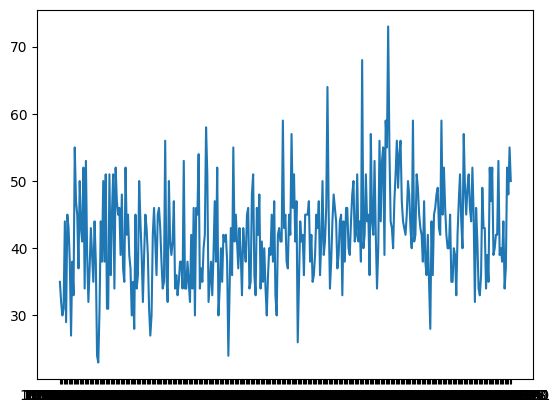

In [43]:
fig, axes = plt.subplots(1,1)
axes.plot(series['Births'])

In [44]:
# evaluate the Random Forest model on the dataset when making one-step forecasts for the last 12 months of data.

values = series.values

# transform a time series dataset into a supervised learning dataset
data = series_to_supervised(values, n_in=6)

# evaluate 
mae, y, yhat = walk_forward_validation(data, 12)

>expected=42.0, predicted=45.4
>expected=53.0, predicted=43.6
>expected=39.0, predicted=41.5
>expected=40.0, predicted=38.5
>expected=38.0, predicted=42.8
>expected=44.0, predicted=47.7
>expected=34.0, predicted=42.6
>expected=37.0, predicted=36.6
>expected=52.0, predicted=38.4
>expected=48.0, predicted=42.0
>expected=55.0, predicted=43.7
>expected=50.0, predicted=45.3


/tmp/ipykernel_1345954/3088708185.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


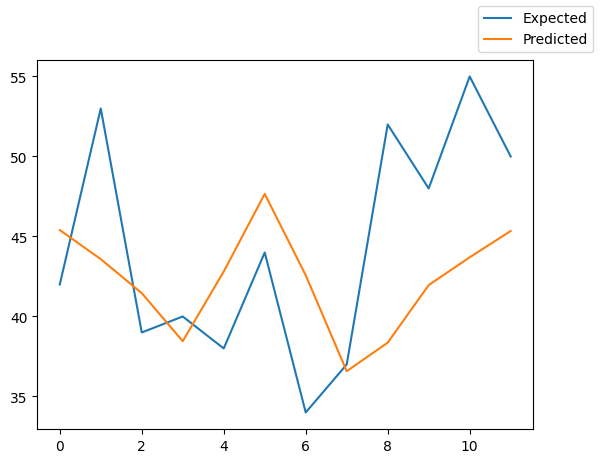

In [46]:
fig, axes = plt.subplots(1,1)

axes.plot(y, label='Expected')
axes.plot(yhat, label='Predicted')

fig.legend()
fig.show()

In [47]:
mae

5.826749999999998